# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/laureano/Doc

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [5]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [6]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


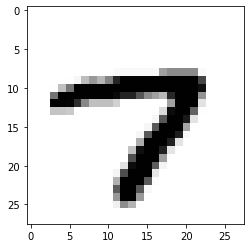

In [7]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [8]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
4    0.0954
8    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [9]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

clf = metnum.KNNClassifier(100)
#clf = KNeighborsClassifier(100)

clf.fit(X_train, y_train)


In [11]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))


Accuracy: 0.832
CPU times: user 1.54 s, sys: 765 µs, total: 1.54 s
Wall time: 1.56 s


### Búsqueda de k vecinos ideal

Buscamos cual es el número de k vecinos que parece ser el ideal. Notemos que la calidad del número elegido no sólo depende de la exactitud(accuracy) obtenido al predecir sino de diferentes métricas.

Dentro de estas métricas tenemos: 
    Exactitud
    Tiempo de ejecución
    Curvas de precisión
    Kappa de Cohen
    F1-Score

In [40]:
import sklearn.metrics as sk ## No se si podemos usar las de sk learn

def metricas(clf, X_train, y_train, X_val, y_val):
    %time clf.fit(X_train, y_train) ### Tiempo de ejecución del fit
    y_pred = clf.predict(X_val) 
    acc = sk.accuracy_score(y_val, y_pred)
    recall = sk.recall_score(y_val, y_pred, average=None) ### Cantidad de true positive / (true positive + false negative)
    ### average = None hace el recall de cada etiqueta, hay average con peso y otras...
    f1 = sk.f1_score(y_val, y_pred, average=None)
    print("Accuracy: {}".format(acc))
    print("Recall: {}".format(recall))
    print("F1: {}".format(f1))
    
    

In [41]:
metricas(clf,X_train,y_train,X_val,y_val)

CPU times: user 8.62 ms, sys: 3.79 ms, total: 12.4 ms
Wall time: 12.2 ms
Accuracy: 0.832
Recall: [0.91489362 0.98214286 0.68695652 0.85454545 0.80681818 0.72222222
 0.93203883 0.84536082 0.71276596 0.84536082]
F1: [0.9197861  0.75862069 0.80612245 0.84684685 0.87654321 0.79268293
 0.90995261 0.86772487 0.79761905 0.77725118]


### IDEA

Hacemos un grafiquito con las accuracys por K. Nos quedamos con las 5 mejores k. Analizamos en las 5 mejores sus métricas. Vemos si hay razones para preferir un k de menor accuracy.

#### Las k de mejor accuracy

Buscamos dentro del intervalo 1 a 100 con saltos de a 2, para darnos una idea de donde pueden ubicarse los k de mejor accuracy

In [47]:
accs = []
from tqdm import tqdm
for k in tqdm(range(1,100,2)):
    clf = metnum.KNNClassifier(k)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    acc = sk.accuracy_score(y_val, y_pred)
    accs.append((acc,k))

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


In [49]:
print((accs))

[(0.93, 1), (0.926, 3), (0.928, 5), (0.926, 7), (0.931, 9), (0.923, 11), (0.922, 13), (0.914, 15), (0.913, 17), (0.912, 19), (0.913, 21), (0.909, 23), (0.908, 25), (0.905, 27), (0.902, 29), (0.902, 31), (0.903, 33), (0.901, 35), (0.9, 37), (0.895, 39), (0.895, 41), (0.891, 43), (0.884, 45), (0.88, 47), (0.879, 49), (0.878, 51), (0.876, 53), (0.873, 55), (0.873, 57), (0.871, 59), (0.869, 61), (0.864, 63), (0.863, 65), (0.863, 67), (0.862, 69), (0.864, 71), (0.857, 73), (0.855, 75), (0.852, 77), (0.852, 79), (0.851, 81), (0.849, 83), (0.847, 85), (0.848, 87), (0.845, 89), (0.842, 91), (0.839, 93), (0.835, 95), (0.835, 97), (0.832, 99)]


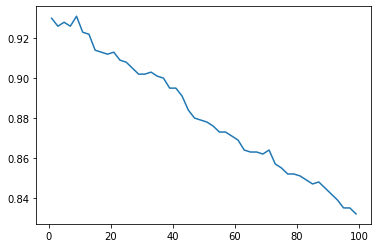

In [56]:
acc_grafico, k_grafico = zip(*accs)
plt.plot(k_grafico,acc_grafico)


Observamos que las k de mejor accuracy están en los números mas bajos

In [77]:
accs = []
from tqdm import tqdm
for k in tqdm(range(1,15,1)):
    clf = metnum.KNNClassifier(k)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    acc = sk.accuracy_score(y_val, y_pred)
    accs.append((acc,k))

100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


[(0.931, 9), (0.931, 8), (0.93, 1), (0.929, 6), (0.928, 5)]
[(0.93, 1), (0.916, 2), (0.926, 3), (0.922, 4), (0.928, 5), (0.929, 6), (0.926, 7), (0.931, 8), (0.931, 9), (0.925, 10), (0.923, 11), (0.923, 12), (0.922, 13), (0.913, 14)]


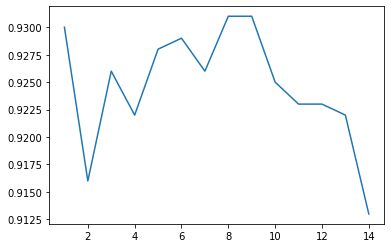

In [88]:
accs.sort(reverse = True)
mejores5 = accs
accs_copy = accs
mejores5 = mejores5[:5]
print(mejores5)
accs.sort(key= lambda x: x[1])
print(accs)
acc_grafico, k_grafico = zip(*accs_copy)
plt.plot(k_grafico,acc_grafico)

In [90]:
for tupla in mejores5:
    clf = metnum.KNNClassifier(tupla[1])
    metricas(clf, X_train, y_train, X_val, y_val)

CPU times: user 13.1 ms, sys: 9 µs, total: 13.1 ms
Wall time: 12.9 ms
Accuracy: 0.931
Recall: [0.96808511 0.98214286 0.89565217 0.94545455 0.93181818 0.91111111
 0.99029126 0.88659794 0.86170213 0.92783505]
F1: [0.96296296 0.90534979 0.94063927 0.94977169 0.95348837 0.91620112
 0.97142857 0.91005291 0.91011236 0.89108911]
CPU times: user 9.63 ms, sys: 0 ns, total: 9.63 ms
Wall time: 9.42 ms
Accuracy: 0.931
Recall: [0.96808511 0.98214286 0.89565217 0.96363636 0.92045455 0.9
 0.99029126 0.89690722 0.86170213 0.91752577]
F1: [0.95789474 0.92436975 0.94063927 0.94642857 0.94736842 0.91525424
 0.96682464 0.91099476 0.91011236 0.88557214]
CPU times: user 9.29 ms, sys: 0 ns, total: 9.29 ms
Wall time: 9.14 ms
Accuracy: 0.93
Recall: [0.95744681 0.98214286 0.88695652 0.91818182 0.96590909 0.92222222
 0.98058252 0.92783505 0.86170213 0.89690722]
F1: [0.95744681 0.94420601 0.92727273 0.91818182 0.96590909 0.91712707
 0.96650718 0.91370558 0.89010989 0.89690722]
CPU times: user 9.45 ms, sys: 0 ns, 